# CS246 - Colab 6
## node2vec

### Setup

First of all, we install the [graph2vec library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

If you are curious to learn how to implement fast random walks on graphs, I recommend you to [read the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [1]:
!pip install nodevectors

  Created wheel for nodevectors: filename=nodevectors-0.1.23-py3-none-any.whl size=17951 sha256=975059bc43ee4f1535a74d09166947dc8f27cdfd10d701b049a4f34b92fbb61a
  Stored in directory: /root/.cache/pip/wheels/6e/6a/11/ac8620f101db6248c3cd436636eb17f6f7430cd1ac3a3068dc
  Created wheel for csrgraph: filename=csrgraph-0.1.28-py3-none-any.whl size=17632 sha256=9a3bde7e407c9da986786232f4b729e1aec3001fcb0129c75532bdac2ae76840
  Stored in directory: /root/.cache/pip/wheels/3d/0a/58/36a63805f1cd719cbcc5a3c4c109604985a809e7d81bac1649
Successfully built nodevectors csrgraph


We now import the library, and create a small wrapper class which will expose only the few hyperparameters we will need to tune in this Colab

In [2]:
from nodevectors import Node2Vec
import networkx as nx

class Node2VecNew(Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                 n_components=d,
                     walklen=10,
                     epochs=50,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5, 
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for our task.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Example

In the example below, we will try to reproduce the plot in slide 8 of [CS246 - Lecture 12](http://web.stanford.edu/class/cs246/slides/12-graphs2.pdf).

In [4]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2VecNew(1, 1, 2)
n2v.fit(KCG)

Making walks... 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Done, T=3.38
Mapping Walk Names... Done, T=0.04
Training W2V... Done, T=0.45


In [5]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

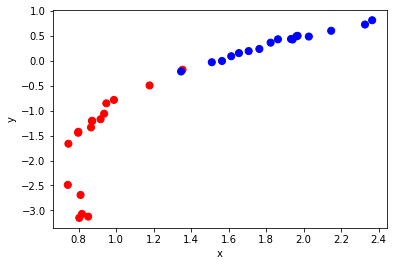

In [6]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

If our example trained correctly, you should notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

### Your Task

Now we will study the behavior of node2vec on [barbell graphs](https://en.wikipedia.org/wiki/Barbell_graph).

Below you can see a toy example of a barbell graph generated with NetworkX.

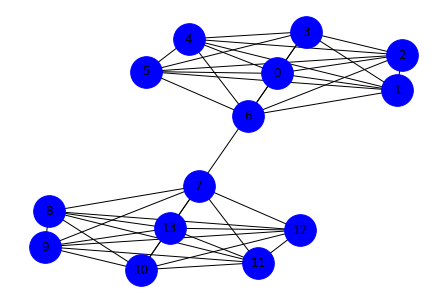

In [12]:
options = {
    'node_color': 'blue',
    'node_size': 1000,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}

toy_barbell = nx.barbell_graph(7, 0)

nx.draw_kamada_kawai(toy_barbell,**options, with_labels = True)




Generate a larger barbell graph, where each complete graph has exactly 1000 nodes, and the path length between the complete graphs is equal to 1 (i.e., all the nodes in the barbell graph belong to either one of the two complete graphs, and the connecting path does not have any internal node).

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [13]:
# YOUR CODE HERE
# Init large barbell graph, where each complete graph has exactly 1000 nodes
large_barbell = nx.barbell_graph(500, 0)

In [15]:
# Setting parameters
p = 1
q = 1
d = 10

# Learn node2vec
n2v_barbell = Node2Vec(p, q, d)

# Fitting data
n2v_barbell.fit(large_barbell)

Making walks... Done, T=0.00
Mapping Walk Names... Done, T=0.02
Training W2V... Done, T=0.66


Write a function that takes as input a node id ```n``` in the graph (e.g., ```5```) and returns a list containing the cosine similarity between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [17]:
# YOUR CODE HERE
from scipy import spatial


def cosine_distance(a, b):
    cosine_distance = float(spatial.distance.cosine(a, b))
    return cosine_distance

def similarity(n=5, g=large_barbell, embed=n2v_barbell):
  result = []
  a= embed.predict(n)
  for node in g.nodes:
    b = embed.predict(node)
    result.append(cosine_distance(a, b))
  return result

Generate another barbell graph, this time adding a path of length 51 between the two complete graphs. To find out how, refer to the NetworkX documentation: [https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph)

Learn the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

In [24]:
# YOUR CODE HERE
# Init large barbell graph, where each complete graph has exactly 1000 nodes
large_barbell_v2 = nx.barbell_graph(500, 51)

# Setting parameters
p = 1
q = 1
d = 10

# Learn node2vec
n2v_barbell_v2 = Node2Vec(p, q, d)

# Fitting data
n2v_barbell_v2.fit(large_barbell_v2)

Making walks... Done, T=0.00
Mapping Walk Names... Done, T=0.02
Training W2V... Done, T=0.72


(array([501.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 499.]),
 array([-1.19209290e-07,  1.99999905e-01,  3.99999928e-01,  5.99999952e-01,
         7.99999976e-01,  1.00000000e+00,  1.20000002e+00,  1.40000005e+00,
         1.60000007e+00,  1.80000010e+00,  2.00000012e+00]),
 <a list of 10 Patch objects>)

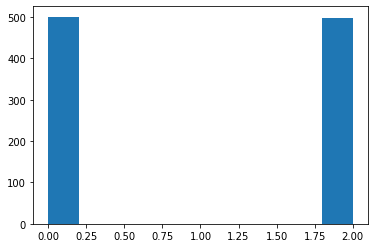

In [25]:
plt.hist(similarity(n=5, g=large_barbell, embed=n2v_barbell))

(array([525.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 526.]),
 array([-1.19209290e-07,  1.99999905e-01,  3.99999928e-01,  5.99999952e-01,
         7.99999976e-01,  1.00000000e+00,  1.20000002e+00,  1.40000005e+00,
         1.60000007e+00,  1.80000010e+00,  2.00000012e+00]),
 <a list of 10 Patch objects>)

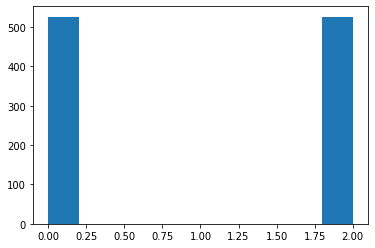

In [26]:
plt.hist(similarity(n=5, g=large_barbell_v2, embed=n2v_barbell_v2))

Once you have working code for each cell above, **head over to Gradescope, read carefully the questions, and submit your solution for this Colab**!
